# TBL: Orca image normalization workflow

This notebook shows how to use the workflow to compute normalized images recorded by the Orca detector on the TBL instrument.

In [1]:
import ess.tbl.data  # noqa: F401
from ess import tbl
from ess.imaging.types import *
import scipp as sc
import plopp as pp

%matplotlib widget

## Workflow setup

In [2]:
wf = tbl.OrcaNormalizedImagesWorkflow()

wf[Filename[SampleRun]] = tbl.data.tbl_lego_sample_run()
wf[Filename[DarkBackgroundRun]] = tbl.data.tbl_lego_dark_run()
wf[Filename[OpenBeamRun]] = tbl.data.tbl_lego_openbeam_run()
wf[NeXusDetectorName] = 'orca_detector'

wf[MaskingRules] = {}  # No masks to begin with
wf[UncertaintyBroadcastMode] = UncertaintyBroadcastMode.upper_bound

In [3]:
wf.visualize(NormalizedImage, compact=True, graph_attr={"rankdir": "LR"})

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Run the workflow

We compute the final normalized image:

In [4]:
image = wf.compute(NormalizedImage)
image

<scipp.DataArray>
Dimensions: Sizes[time:36, dim_1:256, dim_2:256, ]
Coordinates:
* position                  vector3              [m]  (dim_1, dim_2)  [(-0.1, -0.1, 0), (-0.0992157, -0.1, 0), ..., (0.0992157, 0.1, 0), (0.1, 0.1, 0)]
* time                    datetime64             [ns]  (time)  [2024-08-14T14:16:57.997255602, 2024-08-14T14:17:46.682255224, ..., 2024-08-14T14:44:41.925222722, 2024-08-14T14:45:30.825154517]
* x_pixel_offset            float64              [m]  (dim_2)  [-0.1, -0.0992157, ..., 0.0992157, 0.1]
* y_pixel_offset            float64              [m]  (dim_1)  [-0.1, -0.0992157, ..., 0.0992157, 0.1]
Data:
                            float64  [dimensionless]  (time, dim_1, dim_2)  [1.01004, 1.02348, ..., 0.961188, 0.966058]  [0.0156084, 0.0132121, ..., 0.591913, 0.605318]

In [5]:
pp.slicer(image, autoscale=False)

InteractiveFigure(children=(HBar(), HBar(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', la…

## Adding masks

If we want to mask some part of the image, we update the masking rules.
For example, here we mask the upper part of the image:

In [6]:
wf[MaskingRules] = {'y_pixel_offset': lambda x: x > sc.scalar(0.082, unit='m')}

pp.slicer(wf.compute(NormalizedImage), autoscale=False)

InteractiveFigure(children=(HBar(), HBar(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', la…

## Intermediate results

We can also inspect intermediate results, which is useful for debugging:

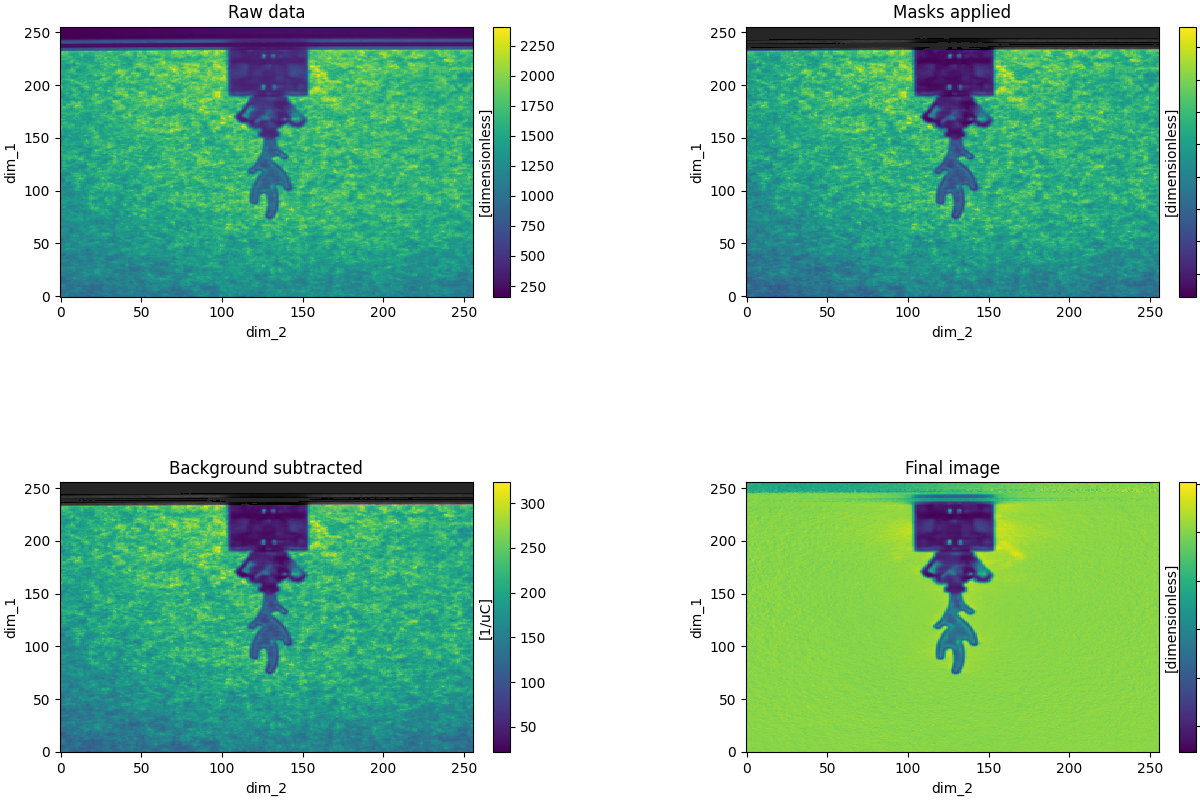

In [7]:
results = wf.compute([
    RawDetector[SampleRun],
    CorrectedDetector[SampleRun],
    BackgroundSubtractedDetector[SampleRun]
])

fig = pp.tiled(2, 2, hspace=0.3, wspace=0.3)
fig[0, 0] = results[RawDetector[SampleRun]]['time', 0].plot(title='Raw data')
fig[0, 1] = results[CorrectedDetector[SampleRun]]['time', 0].plot(title='Masks applied')
fig[1, 0] = results[BackgroundSubtractedDetector[SampleRun]]['time', 0].plot(title='Background subtracted')
fig[1, 1] = image['time', 0].plot(title='Final image')
fig